In [ ]:
data_dir = "/content/drive/MyDrive/Quora-Data/"

In [ ]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve

In [ ]:
with open(data_dir + "pre-processing/glove_twiiter_100_max_train", "rb") as f:
    X_train_max = pickle.load(f)
with open(data_dir + "pre-processing/glove_twiiter_100_max_test", "rb") as f:
    X_test_max = pickle.load(f)
with open(data_dir + "pre-processing/glove_twiiter_100_avg_train", "rb") as f:
    X_train_avg = pickle.load(f)
with open(data_dir + "pre-processing/glove_twiiter_100_avg_test", "rb") as f:
    X_test_avg = pickle.load(f)
Y_train = pd.read_csv(data_dir + "pre-processing/train.csv")["Y"].values
Y_test = pd.read_csv(data_dir + "pre-processing/test.csv")["Y"].values

X_train, X_test = np.hstack((X_train_avg, X_train_max)), np.hstack((X_test_avg, X_test_max))

def remove_nan(X, Y):
    Y = Y[~np.isnan(X).any(axis=1)]
    X = X[~np.isnan(X).any(axis=1)]
    return X, Y

X_train, Y_train = remove_nan(X_train, Y_train)
X_test, Y_test = remove_nan(X_test, Y_test)
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2)

X_train_t = torch.from_numpy(X_train.astype('float32'))
X_test_t = torch.from_numpy(X_test.astype('float32'))
X_val_t = torch.from_numpy(X_val.astype('float32'))
Y_train_t = torch.from_numpy(Y_train)
Y_test_t = torch.from_numpy(Y_test)
Y_val_t = torch.from_numpy(Y_val)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
loss_list_train = []
loss_list_val = []
accuracy_list_train = []
accuracy_list_val = []
iteration_list_val = []
iteration_list_train = []
loss_train_epoch = []

In [ ]:
model = torch.nn.Sequential(
    torch.nn.Linear(400, 128),
    torch.nn.ReLU(),
    #torch.nn.Dropout(0.2),
    torch.nn.Linear(128, 64),
    torch.nn.ReLU(),
    #torch.nn.Dropout(0.2),
    torch.nn.Linear(64, 32),
    torch.nn.ReLU(),
    #torch.nn.Dropout(0.2),
    torch.nn.Linear(32, 1)
    #torch.nn.Sigmoid()
    #torch.nn.Softmax()
)
# inp_dim = 200
# class Net(nn.Module):
#     def __init__(self, input_shape):
#         super(Net,self).__init__()
#         self.fc1 = nn.Linear(input_shape, 120)
#         self.fc2 = nn.Linear(120, 80)
#         self.fc3 = nn.Linear(80, 1)

#     def forward(self,x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = torch.sigmoid(self.fc3(x))
#         return x
# model = Net(input_shape=inp_dim)

model.to(device)
num_epochs = 100
count = 0
batch_size = 100

class MyDataset(Dataset):
    def __init__(self, X, Y, transform = None):
        self.transform = transform
        self.X = torch.tensor(X, dtype=torch.float32) #X
        self.Y = torch.tensor(Y, dtype=torch.float32) #torch.from_numpy(np.asarray(Y).astype('long'))

    def __getitem__(self, index):
        label = self.Y[index]
        image = self.X[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.X)

error = nn.BCEWithLogitsLoss() #nn.CrossEntropyLoss()

# After running several times, this was found to be the best
learning_rate = 0.001
# https://pytorch.org/docs/stable/optim.html
#optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=0.008)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.008)
#optimizer = torch.optim.ASGD(model.parameters())
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
train_dataset = MyDataset(X_train_t, Y_train_t)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = MyDataset(X_test_t, Y_test_t)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

val_dataset = MyDataset(X_val_t, Y_val_t)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(num_epochs):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%500 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 500, Val Loss: 361.557, Val Accuracy: 0.709 Train Loss: 1439.734, Train Accuracy: 0.711
Iteration: 1000, Val Loss: 356.078, Val Accuracy: 0.719 Train Loss: 1416.012, Train Accuracy: 0.721
Iteration: 1500, Val Loss: 347.157, Val Accuracy: 0.724 Train Loss: 1377.151, Train Accuracy: 0.728
Iteration: 2000, Val Loss: 344.704, Val Accuracy: 0.726 Train Loss: 1367.463, Train Accuracy: 0.728
Iteration: 2500, Val Loss: 341.984, Val Accuracy: 0.727 Train Loss: 1353.188, Train Accuracy: 0.731
Iteration: 3000, Val Loss: 337.522, Val Accuracy: 0.733 Train Loss: 1336.682, Train Accuracy: 0.737
Iteration: 3500, Val Loss: 337.601, Val Accuracy: 0.732 Train Loss: 1340.634, Train Accuracy: 0.735
Iteration: 4000, Val Loss: 333.669, Val Accuracy: 0.738 Train Loss: 1317.279, Train Accuracy: 0.743
Iteration: 4500, Val Loss: 333.329, Val Accuracy: 0.739 Train Loss: 1316.136, Train Accuracy: 0.742
Iteration: 5000, Val Loss: 334.607, Val Accuracy: 0.737 Train Loss: 1318.094, Train Accuracy: 0.742
I

KeyboardInterrupt: ignored

In [ ]:
learning_rate = 0.0001
# https://pytorch.org/docs/stable/optim.html
#optimizer = torch.optim.Adagrad(model.parameters(), weight_decay=0.008)
#optimizer = torch.optim.ASGD(model.parameters())
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.008)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
train_dataset = MyDataset(X_train_t, Y_train_t)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = MyDataset(X_test_t, Y_test_t)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

val_dataset = MyDataset(X_val_t, Y_val_t)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(num_epochs):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%500 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 20500, Val Loss: 318.554, Val Accuracy: 0.752 Train Loss: 1248.303, Train Accuracy: 0.760
Iteration: 21000, Val Loss: 315.716, Val Accuracy: 0.756 Train Loss: 1236.734, Train Accuracy: 0.762
Iteration: 21500, Val Loss: 314.722, Val Accuracy: 0.756 Train Loss: 1229.825, Train Accuracy: 0.764
Iteration: 22000, Val Loss: 313.764, Val Accuracy: 0.758 Train Loss: 1224.026, Train Accuracy: 0.767
Iteration: 22500, Val Loss: 313.301, Val Accuracy: 0.758 Train Loss: 1222.377, Train Accuracy: 0.767
Iteration: 23000, Val Loss: 312.456, Val Accuracy: 0.759 Train Loss: 1219.473, Train Accuracy: 0.768
Iteration: 23500, Val Loss: 311.385, Val Accuracy: 0.760 Train Loss: 1214.988, Train Accuracy: 0.768
Iteration: 24000, Val Loss: 312.193, Val Accuracy: 0.758 Train Loss: 1213.465, Train Accuracy: 0.768
Iteration: 24500, Val Loss: 311.694, Val Accuracy: 0.760 Train Loss: 1211.806, Train Accuracy: 0.769
Iteration: 25000, Val Loss: 311.292, Val Accuracy: 0.761 Train Loss: 1210.068, Train Accura

KeyboardInterrupt: ignored

In [ ]:
learning_rate = 0.00005
# https://pytorch.org/docs/stable/optim.html
#optimizer = torch.optim.Adagrad(model.parameters(), weight_decay=0.008)
#optimizer = torch.optim.ASGD(model.parameters())
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.008)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
train_dataset = MyDataset(X_train_t, Y_train_t)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = MyDataset(X_test_t, Y_test_t)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

val_dataset = MyDataset(X_val_t, Y_val_t)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(num_epochs):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%500 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 98500, Val Loss: 296.953, Val Accuracy: 0.775 Train Loss: 1103.076, Train Accuracy: 0.797
Iteration: 99000, Val Loss: 295.689, Val Accuracy: 0.775 Train Loss: 1098.691, Train Accuracy: 0.798
Iteration: 99500, Val Loss: 295.777, Val Accuracy: 0.775 Train Loss: 1096.390, Train Accuracy: 0.800
Iteration: 100000, Val Loss: 295.752, Val Accuracy: 0.776 Train Loss: 1095.234, Train Accuracy: 0.800
Iteration: 100500, Val Loss: 295.537, Val Accuracy: 0.776 Train Loss: 1094.635, Train Accuracy: 0.799
Iteration: 101000, Val Loss: 295.777, Val Accuracy: 0.777 Train Loss: 1095.762, Train Accuracy: 0.800
Iteration: 101500, Val Loss: 295.102, Val Accuracy: 0.776 Train Loss: 1094.200, Train Accuracy: 0.800
Iteration: 102000, Val Loss: 296.448, Val Accuracy: 0.775 Train Loss: 1094.952, Train Accuracy: 0.798
Iteration: 102500, Val Loss: 295.898, Val Accuracy: 0.776 Train Loss: 1094.625, Train Accuracy: 0.799
Iteration: 103000, Val Loss: 295.716, Val Accuracy: 0.776 Train Loss: 1093.114, Train

KeyboardInterrupt: ignored

In [ ]:
learning_rate = 0.000005
# https://pytorch.org/docs/stable/optim.html
#optimizer = torch.optim.Adagrad(model.parameters(), weight_decay=0.008)
#optimizer = torch.optim.ASGD(model.parameters())
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
train_dataset = MyDataset(X_train_t, Y_train_t)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = MyDataset(X_test_t, Y_test_t)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

val_dataset = MyDataset(X_val_t, Y_val_t)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(num_epochs):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%500 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 120000, Val Loss: 293.778, Val Accuracy: 0.778 Train Loss: 1079.285, Train Accuracy: 0.803
Iteration: 120500, Val Loss: 293.590, Val Accuracy: 0.777 Train Loss: 1078.693, Train Accuracy: 0.803
Iteration: 121000, Val Loss: 293.742, Val Accuracy: 0.778 Train Loss: 1078.675, Train Accuracy: 0.804
Iteration: 121500, Val Loss: 293.642, Val Accuracy: 0.777 Train Loss: 1078.407, Train Accuracy: 0.804
Iteration: 122000, Val Loss: 293.728, Val Accuracy: 0.778 Train Loss: 1078.994, Train Accuracy: 0.803
Iteration: 122500, Val Loss: 293.667, Val Accuracy: 0.778 Train Loss: 1078.979, Train Accuracy: 0.804
Iteration: 123000, Val Loss: 293.584, Val Accuracy: 0.778 Train Loss: 1078.941, Train Accuracy: 0.804
Iteration: 123500, Val Loss: 293.787, Val Accuracy: 0.777 Train Loss: 1078.917, Train Accuracy: 0.803
Iteration: 124000, Val Loss: 293.682, Val Accuracy: 0.777 Train Loss: 1078.927, Train Accuracy: 0.804
Iteration: 124500, Val Loss: 293.756, Val Accuracy: 0.778 Train Loss: 1079.420, Tr

KeyboardInterrupt: ignored

In [ ]:
learning_rate = 0.000004
# https://pytorch.org/docs/stable/optim.html
#optimizer = torch.optim.Adagrad(model.parameters(), weight_decay=0.008)
#optimizer = torch.optim.ASGD(model.parameters())
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
train_dataset = MyDataset(X_train_t, Y_train_t)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = MyDataset(X_test_t, Y_test_t)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

val_dataset = MyDataset(X_val_t, Y_val_t)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(num_epochs):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%500 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 137000, Val Loss: 293.674, Val Accuracy: 0.778 Train Loss: 1078.680, Train Accuracy: 0.804
Iteration: 137500, Val Loss: 293.564, Val Accuracy: 0.777 Train Loss: 1077.806, Train Accuracy: 0.804
Iteration: 138000, Val Loss: 293.683, Val Accuracy: 0.777 Train Loss: 1077.092, Train Accuracy: 0.804
Iteration: 138500, Val Loss: 293.552, Val Accuracy: 0.778 Train Loss: 1075.958, Train Accuracy: 0.804
Iteration: 139000, Val Loss: 293.556, Val Accuracy: 0.778 Train Loss: 1075.494, Train Accuracy: 0.804
Iteration: 139500, Val Loss: 293.468, Val Accuracy: 0.778 Train Loss: 1074.595, Train Accuracy: 0.804
Iteration: 140000, Val Loss: 293.390, Val Accuracy: 0.777 Train Loss: 1073.940, Train Accuracy: 0.804
Iteration: 140500, Val Loss: 293.567, Val Accuracy: 0.778 Train Loss: 1073.252, Train Accuracy: 0.804
Iteration: 141000, Val Loss: 293.456, Val Accuracy: 0.778 Train Loss: 1072.529, Train Accuracy: 0.804
Iteration: 141500, Val Loss: 293.466, Val Accuracy: 0.778 Train Loss: 1072.189, Tr

KeyboardInterrupt: ignored

Text(0.5, 1.0, 'Training set Loss-Epoch')

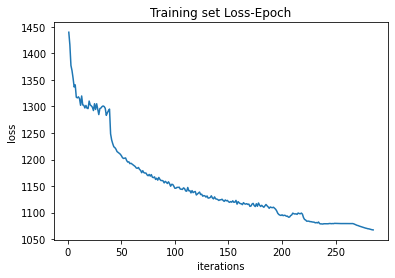

In [ ]:
loss_train_epoch_m = [i.item() for i in loss_train_epoch]
plt.plot([i+1 for i in range(len(iteration_list_train))], loss_train_epoch_m)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.title("Training set Loss-Epoch")

Text(0.5, 1.0, 'Validation set Loss-iteration')

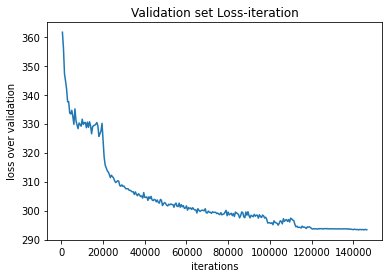

In [ ]:
loss_list_val_m = [i.item() for i in loss_list_val]
plt.plot(iteration_list_val, loss_list_val_m)
plt.xlabel("iterations")
plt.ylabel("loss over validation")
plt.title("Validation set Loss-iteration")

Text(0.5, 1.0, 'Validation set Accuracy-iteration')

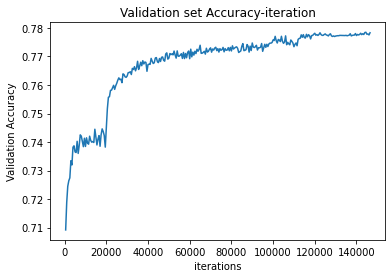

In [ ]:
accuracy_list_val_m = [i for i in accuracy_list_val]
plt.plot(iteration_list_val, accuracy_list_val_m)
plt.xlabel("iterations")
plt.ylabel("Validation Accuracy")
plt.title("Validation set Accuracy-iteration")

Text(0.5, 1.0, 'Training set Accuracy-iteration')

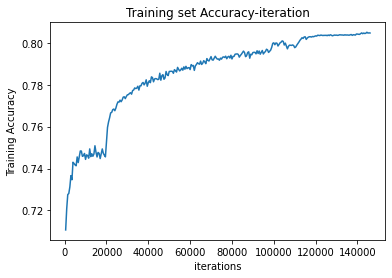

In [ ]:
accuracy_list_train_m = [i for i in accuracy_list_train]
plt.plot(iteration_list_train, accuracy_list_train_m)
plt.xlabel("iterations")
plt.ylabel("Training Accuracy")
plt.title("Training set Accuracy-iteration")

In [ ]:
with open(data_dir + "Models/glove_twitter_avg_max_fc.sav", "wb") as f:
    pickle.dump(model, f)

Test Accuracy: 0.7777736535392153, Test Loss: 367.700439453125
Test Confusion Matrix
Test AUC:  0.8536644135781128


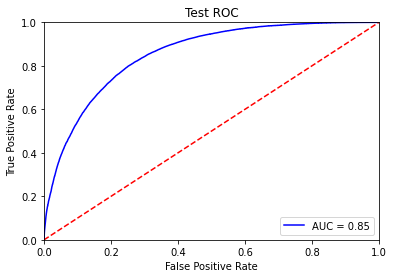

              precision    recall  f1-score   support

         0.0       0.82      0.84      0.83     51093
         1.0       0.71      0.67      0.69     29730

    accuracy                           0.78     80823
   macro avg       0.76      0.76      0.76     80823
weighted avg       0.78      0.78      0.78     80823



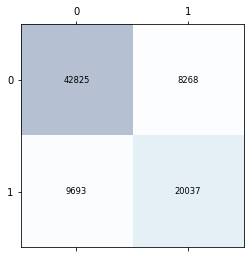

In [ ]:
total = 0
correct = 0
loss = 0
predictions_l = []
labels_l = []
probas_l = []
for images, labels in DataLoader(test_dataset, batch_size=batch_size):
    images, labels = images.to(device), labels.to(device)
    test = images #.view(batch_size, inp_dim))
    outputs = model(test)
    loss += error(outputs, labels.reshape(-1, 1)).data
    proba = torch.sigmoid(outputs).reshape(-1)
    probas_l.append(proba)
    predictions = torch.round(torch.sigmoid(outputs)).reshape(-1) #torch.max(outputs, 1)[1].to(device)
    correct += (predictions == labels).sum().item()
    predictions_l.append(predictions)
    labels_l.append(labels)
    total += len(labels)
accuracy = correct/total 
print("Test Accuracy: {}, Test Loss: {}".format(accuracy, loss))
print("Test Confusion Matrix")
y_true = torch.cat(labels_l, dim=0).detach().cpu()
y_pred = torch.cat(predictions_l, dim=0).detach().cpu()
y_proba = torch.cat(probas_l, dim=0).detach().cpu()
roc_auc_sc = roc_auc_score(y_true, y_proba)
print("Test AUC: ", roc_auc_sc)
fpr, tpr, threshold = roc_curve(y_true, y_proba)
plt.title('Test ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_sc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print(classification_report(y_true, y_pred))
conf_matrix = confusion_matrix(y_true, y_pred)
plt.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='small')

Val Accuracy: 0.7783224569325456, Val Loss: 293.3725280761719
Val Confusion Matrix
Val AUC:  0.8545595260634734


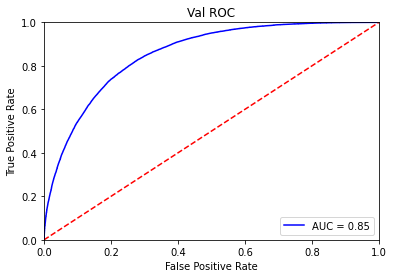

              precision    recall  f1-score   support

         0.0       0.82      0.83      0.83     40783
         1.0       0.71      0.68      0.69     23883

    accuracy                           0.78     64666
   macro avg       0.76      0.76      0.76     64666
weighted avg       0.78      0.78      0.78     64666



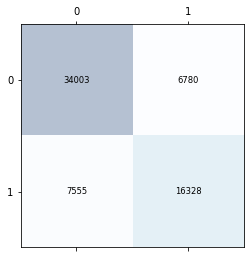

In [ ]:
total = 0
correct = 0
loss = 0
predictions_l = []
labels_l = []
probas_l = []
for images, labels in DataLoader(val_dataset, batch_size=batch_size):
    images, labels = images.to(device), labels.to(device)
    test = images #.view(batch_size, inp_dim))
    outputs = model(test)
    loss += error(outputs, labels.reshape(-1, 1)).data
    proba = torch.sigmoid(outputs).reshape(-1)
    probas_l.append(proba)
    predictions = torch.round(torch.sigmoid(outputs)).reshape(-1) #torch.max(outputs, 1)[1].to(device)
    correct += (predictions == labels).sum().item()
    predictions_l.append(predictions)
    labels_l.append(labels)
    total += len(labels)
accuracy = correct/total 
print("Val Accuracy: {}, Val Loss: {}".format(accuracy, loss))
print("Val Confusion Matrix")
y_true = torch.cat(labels_l, dim=0).detach().cpu()
y_pred = torch.cat(predictions_l, dim=0).detach().cpu()
y_proba = torch.cat(probas_l, dim=0).detach().cpu()
roc_auc_sc = roc_auc_score(y_true, y_proba)
print("Val AUC: ", roc_auc_sc)
fpr, tpr, threshold = roc_curve(y_true, y_proba)
plt.title('Val ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_sc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print(classification_report(y_true, y_pred))
conf_matrix = confusion_matrix(y_true, y_pred)
plt.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='small')

Train Accuracy: 0.804807045487934, Train Loss: 1066.77783203125
Train Confusion Matrix
Train AUC:  0.8836660742465989


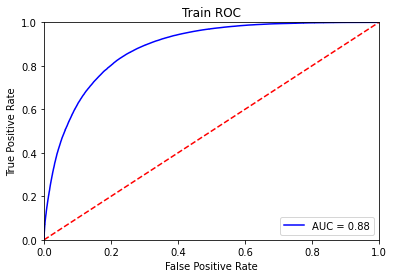

              precision    recall  f1-score   support

         0.0       0.84      0.86      0.85    163016
         1.0       0.75      0.71      0.73     95646

    accuracy                           0.80    258662
   macro avg       0.79      0.79      0.79    258662
weighted avg       0.80      0.80      0.80    258662



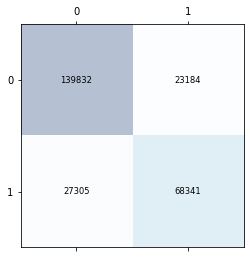

In [ ]:
total = 0
correct = 0
loss = 0
predictions_l = []
labels_l = []
probas_l = []
for images, labels in DataLoader(train_dataset, batch_size=batch_size):
    images, labels = images.to(device), labels.to(device)
    test = images #.view(batch_size, inp_dim))
    outputs = model(test)
    loss += error(outputs, labels.reshape(-1, 1)).data
    proba = torch.sigmoid(outputs).reshape(-1)
    probas_l.append(proba)
    predictions = torch.round(torch.sigmoid(outputs)).reshape(-1) #torch.max(outputs, 1)[1].to(device)
    correct += (predictions == labels).sum().item()
    predictions_l.append(predictions)
    labels_l.append(labels)
    total += len(labels)
accuracy = correct/total 
print("Train Accuracy: {}, Train Loss: {}".format(accuracy, loss))
print("Train Confusion Matrix")
y_true = torch.cat(labels_l, dim=0).detach().cpu()
y_pred = torch.cat(predictions_l, dim=0).detach().cpu()
y_proba = torch.cat(probas_l, dim=0).detach().cpu()
roc_auc_sc = roc_auc_score(y_true, y_proba)
print("Train AUC: ", roc_auc_sc)
fpr, tpr, threshold = roc_curve(y_true, y_proba)
plt.title('Train ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_sc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print(classification_report(y_true, y_pred))
conf_matrix = confusion_matrix(y_true, y_pred)
plt.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='small')

In [ ]:
interm_model = nn.Sequential(*list(model.children())[:-1])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


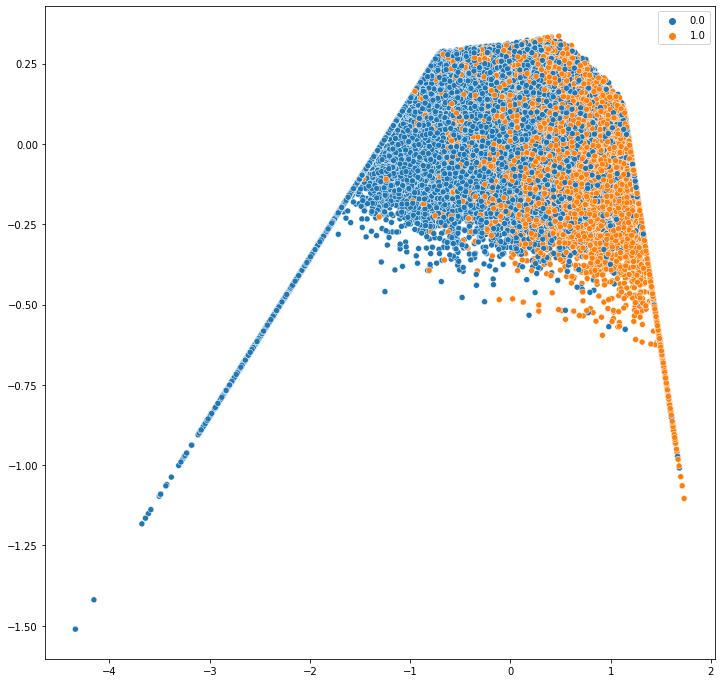

In [ ]:
total = 0
correct = 0
loss = 0
out = []
labels_l = []
for images, labels in DataLoader(val_dataset, batch_size=batch_size):
    images, labels = images.to(device), labels.to(device)
    test = images #.view(batch_size, inp_dim))
    outputs = interm_model(test)
    labels_l.append(labels)
    out.append(outputs)

class pca:
    def __init__(self, n_components):
        """
        :param n_components: Number of principal components the data should be reduced too.
        """
        self.components = n_components

    def fit_transform(self, X):
        """
        * Centering our inputs with mean
        * Finding covariance matrix using centered tensor
        * Finding eigen value and eigen vector using torch.eig()
        * Sorting eigen values in descending order and finding index of high eigen values
        * Using sorted index, get the eigen vectors
        * Tranforming the Input vectors with n columns into PCA components with reduced dimension
        :param X: Input tensor with n columns.
        :return: Output tensor with reduced principal components
        """
        centering_X = X - torch.mean(X, dim=0)
        covariance_matrix = torch.mm(centering_X.T, centering_X)/(centering_X.shape[0] - 1)
        eigen_values, eigen_vectors = torch.eig(covariance_matrix, eigenvectors=True)
        eigen_sorted_index = torch.argsort(eigen_values[:,0],descending=True)
        eigen_vectors_sorted = eigen_vectors[:,eigen_sorted_index]
        component_vector = eigen_vectors_sorted[:,0:self.components]
        transformed = torch.mm(component_vector.T, centering_X.T).T
        return transformed
pca_out = pca(n_components=2).fit_transform(torch.cat(out))
pca_vector = pca_out
plt.figure(figsize=(12, 12))
sb.scatterplot(
    pca_vector[:, 0].detach().cpu(), 
    pca_vector[:, 1].detach().cpu(), 
    hue=torch.cat(labels_l).detach().cpu(), 
    #s=100, 
    palette="tab10"
)
plt.show()